In [0]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [80]:
train = pd.read_csv('./Train_nyOWmfK.csv', engine='python')
#test = pd.read_csv('./dataset/Test_bCtAN1w.csv', engine='python')

print('Shape of tain dataser:', train.shape)
#print('Shape of test dataser:', test.shape)

#a = set(list(train.columns))-set(list(test.columns))
#print('Features in train dataset and not in test dataset: ', a)
train.head()

Shape of tain dataser: (87020, 26)


,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [81]:
all_columns=list(train.columns)
print('Columns names=', all_columns)

Columns names= ['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed']


Monthly_Income = Monthly Income

DOB = date of birth

Lead_Creation_Date       = Creation Date

Loan_Amount_Applied      = Loan Amount Applied by a borrower 

Loan_Tenure_Applied      = Tenure Applied by a borrower (number of years)

Existing_EMI             = existing equated monthly installment (EMI) is a fixed payment amount made by a borrower to a lender at a specified date each calendar month.

Employer_Name            = Employer Name

Salary_Account           = Bank name

Mobile_Verified          = phone number (yes or no)

Var5                     = ?

Var1                     = ?

Loan_Amount_Submitted    = Loan Amount requested by customer

Loan_Tenure_Submitted    = Loan Tenure requested by customer

Interest_Rate            = Interest Rate per year (%)

Processing_Fee           = Processing Fee

EMI_Loan_Submitted       = EMI Loan requested by customer

Filled_Form              = Filled Form (yes or no)

Device_Type              = Device Type (directly or online or ...)

Var2                     = ?

Source                   = source

Var4                     = ?

LoggedIn                 = ?

Disbursed                = loan disbursed (1--> yes and 0-->no)

In [0]:
numerical_columns = ['Monthly_Income','Loan_Amount_Applied','Loan_Tenure_Applied','Existing_EMI','Var5','Loan_Amount_Submitted','Loan_Tenure_Submitted','Interest_Rate','Processing_Fee','EMI_Loan_Submitted','Var4','LoggedIn','Disbursed']
date_columns = ['DOB','Lead_Creation_Date']
object_columns = ['ID','Gender','City','Employer_Name','Salary_Account','Mobile_Verified','Var1','Filled_Form','Device_Type','Var2','Source' ]

df_num = train[numerical_columns]
df_date = train[date_columns]
df_categorial = train[object_columns]

## Numerical features

In [83]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 13 columns):
Monthly_Income           87020 non-null int64
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Var5                     87020 non-null int64
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null float64
Var4                     87020 non-null int64
LoggedIn                 87020 non-null int64
Disbursed                87020 non-null int64
dtypes: float64(8), int64(5)
memory usage: 8.6 MB


In [84]:
# There are many columns with missing values. For columns concerning the informations given by the customers.They must 
# not be altered or estimates my mean or median. I'll convert it to 0 or 1 values with 0 for NaN.
# The concerned columns are 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'EMI_Loan_Submitted', 'Processing_Fee'
# and 'Interest_Rate'

df_num_new = pd.DataFrame(train['ID'])

for col in ['EMI_Loan_Submitted','Loan_Amount_Submitted','Loan_Tenure_Submitted','Interest_Rate','Processing_Fee']: 
    df_num_new[col] = df_num[col].apply(lambda x: 0 if np.isnan(x) else 1)
    
    
# Missing value of column 'Existing_EMI' will replaced with 0 because just 111 are missing:
df_num_new['Existing_EMI'] = df_num['Existing_EMI'].fillna(0)

# 'Loan_Amount_Applied' and 'Loan_Tenure_Applied' are applied by a borrower.
# I replace the missing values with median because only 111 missing
for col in ['Loan_Amount_Applied', 'Loan_Tenure_Applied']:
    myMedian = df_num[col].median()
    df_num_new[col] = df_num[col].fillna(myMedian)
    
# add other columns
for col in set(df_num.columns)-set(df_num_new.columns):
    df_num_new[col] = df_num[col]

df_num_new.set_index('ID', inplace = True)
df_num_new.head()

,EMI_Loan_Submitted,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Disbursed,Var5,Var4,Monthly_Income,LoggedIn
ID,,,,,,,,,,,,,
ID000002C20,0,0,0,0,0,0.0,300000.0,5.0,0,0,1,20000,0
ID000004E40,1,1,1,1,0,0.0,200000.0,2.0,0,13,3,35000,0
ID000007H20,0,1,1,0,0,0.0,600000.0,4.0,0,0,1,22500,0
ID000008I30,0,1,1,0,0,0.0,1000000.0,5.0,0,10,3,35000,0
ID000009J40,0,1,1,0,0,25000.0,500000.0,2.0,0,17,3,100000,1


## Date features

In [0]:
from datetime import date 
  
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 
    return age 

In [86]:
df_date_new = pd.DataFrame(train['ID'])

# In date_columns, 'Lead_Creation_Date' is irrelevent and shold be discarded.
# In opposite DOB (date of birth) must be converted to age and renamed 'AGE'
df_date_new['AGE'] = pd.to_datetime(df_date['DOB']).map(calculateAge)

df_date_new.set_index('ID', inplace = True)
df_date_new.head()

,AGE
ID,
ID000002C20,41
ID000004E40,34
ID000007H20,38
ID000008I30,31
ID000009J40,35


## object features

In [87]:
# Drop irrelevent columns because they doesn't appear to affect much intuitively
# Remove the following columns: 'City', Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Filled_Form', 'Device_Type', 'Source'
df_categorial = df_categorial.drop(['City',
                                    'Employer_Name',
                                    'Salary_Account',
                                    'Mobile_Verified', 
                                    'Filled_Form',
                                    'Device_Type',
                                    'Source'], axis=1)

# create the one-hot-encoding of columns 'Gender','Var1' and 'Var2'
df_categorial_new = pd.get_dummies(df_categorial, columns=['Gender','Var1', 'Var2'])

df_categorial_new.set_index('ID', inplace = True)
df_categorial_new.head()

,Gender_Female,Gender_Male,Var1_HAVC,Var1_HAXA,Var1_HAXB,Var1_HAXC,Var1_HAXF,Var1_HAXM,Var1_HAYT,Var1_HAZD,Var1_HBXA,Var1_HBXB,Var1_HBXC,Var1_HBXD,Var1_HBXH,Var1_HBXX,Var1_HCXD,Var1_HCXF,Var1_HCXG,Var1_HCYS,Var1_HVYS,Var2_A,Var2_B,Var2_C,Var2_D,Var2_E,Var2_F,Var2_G
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID000002C20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
ID000004E40,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
ID000007H20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
ID000008I30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
ID000009J40,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


## Concate the data frames

In [88]:
# Concate all subd-dataframes
df_train = pd.concat([df_num_new,df_date_new,df_categorial_new], axis=1)

# move the labels column to end of dataframe
train_columns = list(df_train.columns)
train_columns.pop(train_columns.index('Disbursed'))
train_columns = train_columns+['Disbursed']

df_train = df_train[train_columns]
df_train.head()

,EMI_Loan_Submitted,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Var5,Var4,Monthly_Income,LoggedIn,AGE,Gender_Female,Gender_Male,Var1_HAVC,Var1_HAXA,Var1_HAXB,Var1_HAXC,Var1_HAXF,Var1_HAXM,Var1_HAYT,Var1_HAZD,Var1_HBXA,Var1_HBXB,Var1_HBXC,Var1_HBXD,Var1_HBXH,Var1_HBXX,Var1_HCXD,Var1_HCXF,Var1_HCXG,Var1_HCYS,Var1_HVYS,Var2_A,Var2_B,Var2_C,Var2_D,Var2_E,Var2_F,Var2_G,Disbursed
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID000002C20,0,0,0,0,0,0.0,300000.0,5.0,0,1,20000,0,41,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
ID000004E40,1,1,1,1,0,0.0,200000.0,2.0,13,3,35000,0,34,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ID000007H20,0,1,1,0,0,0.0,600000.0,4.0,0,1,22500,0,38,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
ID000008I30,0,1,1,0,0,0.0,1000000.0,5.0,10,3,35000,0,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
ID000009J40,0,1,1,0,0,25000.0,500000.0,2.0,17,3,100000,1,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


# Check the balance of classes

In [89]:
# Check the balance of classes
df_train['Disbursed'].value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

# Create train and test data sets

In [90]:
from sklearn.model_selection import train_test_split
 

# Create train and test set 
train_X, test_X, train_y, test_y = train_test_split(df_train.iloc[:,:-1], df_train.iloc[:,-1], test_size=0.25)
print("Taille des predictor sur le train set : ", train_X.shape)
print("Balance of train set : ")
print(train_y.value_counts())
print()
print("Taille des predictor sur le test set : ", test_X.shape)
print("Balance of test set : ")
print(test_y.value_counts())

Taille des predictor sur le train set :  (65265, 41)
Balance of train set : 
0    64309
1      956
Name: Disbursed, dtype: int64

Taille des predictor sur le test set :  (21755, 41)
Balance of test set : 
0    21438
1      317
Name: Disbursed, dtype: int64


In [0]:
def optimizeClassifier(clf, train_X, train_y, test_X, test_y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        clf_params = clf.get_xgb_params()
        n_estimators = clf.get_params()['n_estimators']
        dmatrix = xgb.DMatrix(train_X, label=train_y)
        
        
        cvresult = xgb.cv(clf_params, 
                          dmatrix, 
                          num_boost_round=n_estimators,
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds, 
                          )
        
        # the early-stopping estimator number is the last of cvresult
        best_n_estimators = cvresult.shape[0]
        clf.set_params(n_estimators=best_n_estimators)
        
    
    
        
    print('best_n_estimators =', best_n_estimators)
    
    return clf

In [0]:
def fitClassifier(clf,train_X, train_y, test_X, test_y):
    
        #Fit the algorithm on the data
        clf.fit(train_X,train_y,eval_metric='auc')

        #Predict training set:
        train_y_pred = clf.predict(train_X)
        train_y_predprob = clf.predict_proba(train_X)[:,1]

        train_precision = metrics.precision_score(train_y, train_y_pred)
        train_roc_auc = metrics.roc_auc_score(train_y, train_y_predprob)
        train_f1 = f1_score(train_y, train_y_pred)
        train_recall = recall_score(train_y, train_y_pred)
        train_conf_mat = pd.DataFrame(confusion_matrix(train_y, train_y_pred), columns=['pred_0', 'pred_1'], index=['0', '1'])
        train_fpr, train_tpr, _ = roc_curve( train_y, train_y_pred )

        #Predict test set:
        test_y_pred = clf.predict(test_X)
        test_y_predprob = clf.predict_proba(test_X)[:,1]

        test_precision = metrics.precision_score(test_y, test_y_pred)
        test_roc_auc = metrics.roc_auc_score(test_y, test_y_predprob)
        test_f1 = f1_score(test_y, test_y_pred)
        test_recall = recall_score(test_y, test_y_pred)
        test_conf_mat = pd.DataFrame(confusion_matrix(test_y, test_y_pred), columns=['pred_0', 'pred_1'], index=['0', '1'])
        test_fpr, test_tpr, _ = roc_curve( test_y, test_y_pred )

        #Print model report:
        print( "\nModel Report")
        print( "Recall Score:")
        print("Train={}, Test={}".format(train_recall, test_recall))
        print()
        
        print( "Precision:")
        print("Train={}, Test={}".format(train_precision, test_precision))
        print()
        
        print( "F1 Score:")
        print("Train={}, Test={}".format(train_f1, test_f1))
        print()

        
        print("Confusion matrix")
        display_side_by_side([train_conf_mat, test_conf_mat], ['Train', 'Test'])
        print()

        print( "AUC Score:")
        print("Train={}, Test={}".format(train_roc_auc, test_roc_auc))
        print()

        # plot ROC
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Train ROC')
        ax1.plot(train_fpr, train_tpr, lw=2 )
        ax2.set_title('Test ROC')
        ax2.plot(test_fpr, test_tpr, lw=2 )

In [0]:
# helper function
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


best_n_estimators = 87

Model Report
Recall Score:
Train=0.7165271966527197, Test=0.5709779179810726

Precision:
Train=0.7349785407725322, Test=0.5876623376623377

F1 Score:
Train=0.7256355932203389, Test=0.5792

Confusion matrix


,pred_0,pred_1
0,64062,247
1,271,685
,pred_0,pred_1
0,21311,127
1,136,181



AUC Score:
Train=0.9969224327548784, Test=0.9875667429779897



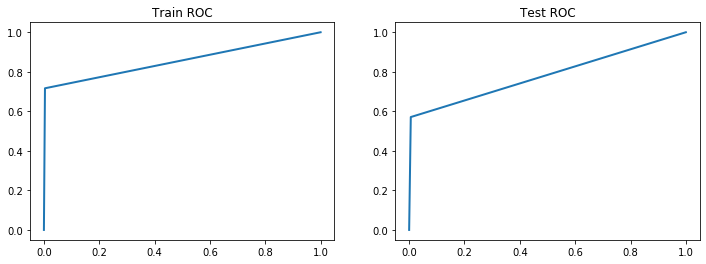

In [94]:
xgb1 = xgb.XGBClassifier(learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=27)

xgb1 = optimizeClassifier(xgb1, train_X, train_y, test_X, test_y)

fitClassifier(xgb1, train_X, train_y, test_X, test_y)

# Step 2: Tune max_depth and min_child_weight

Important Note : I’ll be doing some heavy-duty grid searched in this section which can take a long time (depending on your system).


In [95]:
# Step 2: Tune max_depth and min_child_weight
param_test1 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)
              }

clf1 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=87, 

                         max_depth=5,
                         min_child_weight=1,
                         gamma=0, 
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

gridsearch1 = GridSearchCV(estimator = clf1,
                           param_grid = param_test1, 
                           scoring='roc_auc',
                           n_jobs=4,
                           iid=False, 
                           cv=5)

gridsearch1.fit(train_X,train_y)
gridsearch1.best_params_, gridsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.9929315467919398)

Here, we get the optimum values as 3 for max_depth and 3 for min_child_weight.

Also, we can see the CV score increasing slightly. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance.


## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above.

In [96]:
param_test2 = { 'gamma':[i/10.0 for i in range(0,5)] }

clf2 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=87, 
                         max_depth=3,
                         min_child_weight=3,

                         gamma=0, 
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

gridsearch2 = GridSearchCV(estimator = clf2,
                           param_grid = param_test2, 
                           scoring='roc_auc',
                           n_jobs=4,
                           iid=False, 
                           cv=5)

gridsearch2.fit(train_X,train_y)
gridsearch2.best_params_, gridsearch1.best_score_

({'gamma': 0.1}, 0.9929315467919398)

# Step 4: Tune subsample and colsample_bytree

In [97]:
param_test3 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]
              }

clf3 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=87, 
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0.1,

                         subsample=0.8, 
                         colsample_bytree=0.8,
                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

gridsearch3 = GridSearchCV(estimator = clf3,
                           param_grid = param_test3, 
                           scoring='roc_auc',
                           n_jobs=4,
                           iid=False, 
                           cv=5)

gridsearch3.fit(train_X,train_y)
gridsearch3.best_params_, gridsearch1.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.9929315467919398)

# Step 6: Reducing Learning Rate in order to reduce overfit

In [98]:
param_test4 = {'learning_rate':[i/1000.0 for i in range(5,20,2)]}

clf4 = xgb.XGBClassifier(learning_rate =0.1, 
                         n_estimators=87, 
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0.1,
                         subsample=0.7, 
                         colsample_bytree=0.9,

                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

gridsearch4 = GridSearchCV(estimator = clf4,
                           param_grid = param_test4, 
                           scoring='roc_auc',
                           n_jobs=4,
                           iid=False, 
                           cv=5)

gridsearch4.fit(train_X,train_y)
gridsearch4.best_params_, gridsearch1.best_score_

({'learning_rate': 0.019}, 0.9929315467919398)

# Final fit and evaluation

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


best_n_estimators = 87

Model Report
Recall Score:
Train=0.7165271966527197, Test=0.5709779179810726

Precision:
Train=0.7349785407725322, Test=0.5876623376623377

F1 Score:
Train=0.7256355932203389, Test=0.5792

Confusion matrix


,pred_0,pred_1
0,64062,247
1,271,685
,pred_0,pred_1
0,21311,127
1,136,181



AUC Score:
Train=0.9969224327548784, Test=0.9875667429779897



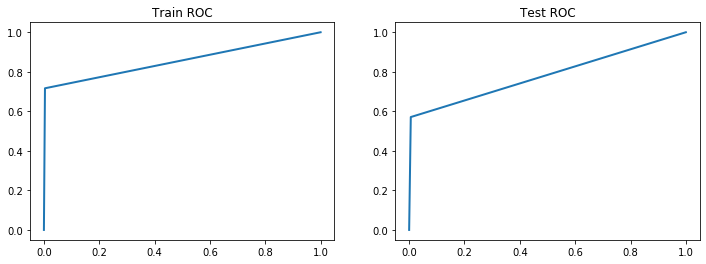

In [99]:
clf5 = xgb.XGBClassifier(learning_rate =0.019, 
                         n_estimators=1000, 
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0.1,
                         subsample=0.7, 
                         colsample_bytree=0.9,

                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

xgb5 = optimizeClassifier(xgb1, train_X, train_y, test_X, test_y)

fitClassifier(xgb1, train_X, train_y, test_X, test_y)

# Upsampling with SMOTE

In [100]:
from collections import Counter
from imblearn.over_sampling import SMOTE 



sm = SMOTE(random_state=42)
X, y = sm.fit_sample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
print(Counter(y))


new_train_X, new_test_X, new_train_y, new_test_y = train_test_split(X, y, test_size=0.25)
print("Taille des predictor sur le train set : ", new_train_X.shape)
print("Taille des predictor sur le test set : ", new_test_X.shape)


Counter({0: 85747, 1: 85747})
Taille des predictor sur le train set :  (128620, 41)
Taille des predictor sur le test set :  (42874, 41)



Model Report
Recall Score:
Train=0.9992062503890929, Test=0.9993952081879507

Precision:
Train=0.9851765464115273, Test=0.9842840778923253

F1 Score:
Train=0.9921418029810151, Test=0.9917820867959373

Confusion matrix


,pred_0,pred_1
0,63402,966
1,51,64201
,pred_0,pred_1
0,21036,343
1,13,21482



AUC Score:
Train=0.9984818707649606, Test=0.9983483562930063



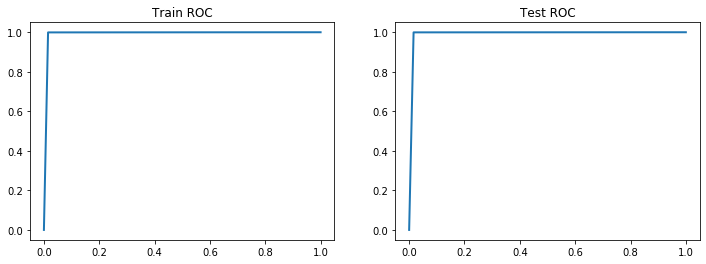

In [101]:

clf6 = xgb.XGBClassifier(learning_rate =0.019, 
                         n_estimators=87, 
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0.1,
                         subsample=0.7, 
                         colsample_bytree=0.9,

                         objective= 'binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1, 
                         seed=27)

fitClassifier(clf6, new_train_X, new_train_y, new_test_X, new_test_y)